<a href="https://colab.research.google.com/github/PietroDF/Computer_vision/blob/master/Siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello di reti siamesi per classificazione caratteri simili

# Librerie

In [ ]:
import keras as K
from keras import Sequential, Input, Model, losses
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Lambda, Concatenate, BatchNormalization, Activation, Dropout
from keras.initializers import RandomNormal, Zeros
from keras.regularizers import l1, l2

from tensorflow.keras.preprocessing import image
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, accuracy_score, average_precision_score

Inspiring tutorial @ https://software.intel.com/content/www/us/en/develop/articles/keras-implementation-of-siamese-like-networks.html

# Dataset

## Get dataset

In [ ]:
!mkdir '/content/dataset_directory'

In [ ]:
!wget --no-check-certificate \
    "https://github.com/brendenlake/omniglot/raw/master/python/images_background_small1.zip" \
    -O /content/dataset_directory/OmniGlot.zip

--2020-10-04 12:52:32--  https://github.com/brendenlake/omniglot/raw/master/python/images_background_small1.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background_small1.zip [following]
--2020-10-04 12:52:33--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background_small1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1319022 (1.3M) [application/zip]
Saving to: ‘/content/dataset_directory/OmniGlot.zip’

/content/dataset_di 100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2020-10-04 12:52:33 (22.2 MB/s) 

In [ ]:
import os
import zipfile

local_zip = '/content/dataset_directory/OmniGlot.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset_directory')
zip_ref.close()

In [ ]:
train_languages = ['Greek','Korean','Early_Aramaic','Balinese']
test_languages = ['Balinese','Latin']

In [ ]:
dataset_folder = '/content/dataset_directory/images_background_small1'

## Prepare dataset with coupled images

In [ ]:
def plot_img_couples(img_pairs, true_labels=[], pred_labels=[], n_couples_to_plot=3, 
                     Plot_TP=True, Plot_FP=True, Plot_FN=True, Plot_TN=True):

  prediction_type_to_plot = {}
  prediction_type_to_plot['TP'] = Plot_TP
  prediction_type_to_plot['FP'] = Plot_FP
  prediction_type_to_plot['TN'] = Plot_TN
  prediction_type_to_plot['FN'] = Plot_FN
  prediction_type_to_plot['no_pred'] = True

  def labels(label_list,_idx):
    try:
      lab = label_list[_idx][0]
    except:
      try:
        lab = label_list[_idx]
      except:
        lab = ''
    return lab

  def check_if_TP_TN_FP_FN(val, pred_val):
    if pred_val == '':
      return 'no_pred'
    else:
      pred_val = int(pred_val>0.5)
      if val == pred_val:
        if val == 1:
          return 'TP' # True Positive
        else:
          return 'TN' # True Negative
      else:
        if pred_val == 1:
          return 'FP' # False Positive
        else:
          return 'FN' # False Negative

  boolvar = (Plot_TP==False and Plot_FP==False and Plot_TN==False and Plot_FN==False)
  
  if boolvar:
    print('Please set something to True')
    return None
    
  else:
    
    magnifier = 3
    plt.figure(figsize=(2*magnifier, 1.2*n_couples_to_plot*magnifier))

    i = 0
    while i < n_couples_to_plot:

      idx = np.random.randint(0,np.shape(img_pairs[0])[0]-1)

      Tlab = labels(true_labels, idx)
      Plab = labels(pred_labels, idx)
      
      prediction_type = check_if_TP_TN_FP_FN(Tlab, Plab)

      if prediction_type_to_plot[prediction_type]:

        plt.subplot(n_couples_to_plot,2, 2*i+1)
        plt.imshow(img_pairs[0][idx])
        plt.title('True Label: '+str(Tlab))
        
        plt.subplot(n_couples_to_plot,2, 2*i+2)
        plt.imshow(img_pairs[1][idx])
        plt.title('Pred Label: '+str(Plab))

        i+=1

    plt.show()

In [ ]:
num_img_couples = 6000

random_threshold = 0.75

img_dimension = 100

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for i in range(num_img_couples):

  dataset_split = random.choice(['train','train','train','train','train','val','val','test','test','test'])

  if dataset_split in ['train','val']:
    languages = train_languages
  else:
    languages = test_languages

  same_alphabet = np.random.rand()<random_threshold

  first_alphabet = random.choice(languages)

  if same_alphabet:
    second_alphabet = first_alphabet
  else:
    second_alphabet = random.choice(languages)

  char_folder_path_1 = dataset_folder+'/'+first_alphabet+'/'
  char_folder_list_1 = os.listdir(char_folder_path_1)

  char_folder_path_2 = dataset_folder+'/'+second_alphabet+'/'
  char_folder_list_2 = os.listdir(char_folder_path_2)

  same_char = np.random.rand()<random_threshold
  char_choice_1 = random.choice(char_folder_list_1)

  if same_char and same_alphabet:
    char_choice_2 = char_choice_1
    label = 1
  else:
    char_choice_2 = random.choice(char_folder_list_2)
    label = 0

  char_path_1 = char_folder_path_1+char_choice_1+'/'
  char_path_2 = char_folder_path_2+char_choice_2+'/'

  img_1 = random.choice(os.listdir(char_path_1))
  img_2 = random.choice(os.listdir(char_path_2))

  img_path_1 = char_path_1 + img_1
  img_path_2 = char_path_2 + img_2

  # print(img_path_1,'\n',img_path_2)

  # # carico le immagini e le trasformo in formto conveniente
  img1 = image.load_img(img_path_1, target_size=(img_dimension,img_dimension))
  img1 = image.img_to_array(img1).astype('uint') #unsigned integer (non necessario)
  img1 = img1/255

  img2 = image.load_img(img_path_2, target_size=(img_dimension,img_dimension))
  img2 = image.img_to_array(img2).astype('uint') #unsigned integer (non necessario)
  img2 = img2/255

  if dataset_split == 'train':
    x_train.append([img1,img2])
    y_train.append(label)

  if dataset_split == 'val':
    x_val.append([img1,img2])
    y_val.append(label)

  if dataset_split == 'test':
    x_test.append([img1,img2])
    y_test.append(label)

In [ ]:
len(x_train),len(x_val),len(x_test), len(y_train),len(y_val),len(y_test)

(2948, 1189, 1863, 2948, 1189, 1863)

In [ ]:
def prepare_image_pairs(img_group, label):

  list_img1, list_img2 = list(), list()

  for i in range(len(img_group)):
    list_img1.append(img_group[i][0])
    list_img2.append(img_group[i][1]) 

  img_pairs = [np.array(list_img1),np.array(list_img2)]

  label = np.array(label)

  return img_pairs, label

In [ ]:
# Create final dataset to feed the model
train_pairs, y_train = prepare_image_pairs(x_train, y_train)
val_pairs, y_val = prepare_image_pairs(x_val, y_val)
test_pairs, y_test = prepare_image_pairs(x_test, y_test)

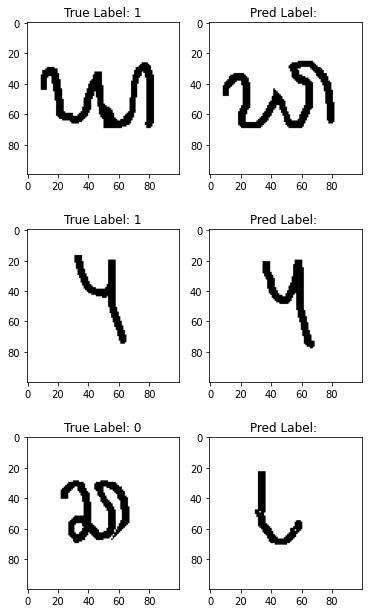

In [ ]:
plot_img_couples(train_pairs, y_train, n_couples_to_plot=3)

In [ ]:
# plot_img_couples(val_pairs, y_val,n_couples_to_plot=3)

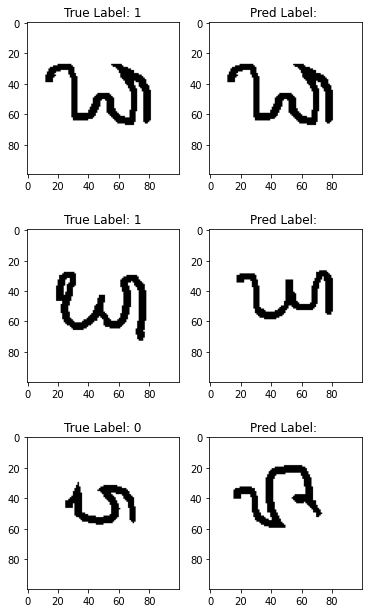

In [ ]:
plot_img_couples(test_pairs, y_test,n_couples_to_plot=3)

# Model

## Architecture design

In [ ]:
def get_siamese_model(input_shape):
    """
        MODEL ARCHITECTURE
        Costruisco il modello attraverso le Functional API di Keras
    """
    initialize_weights = RandomNormal()
    initialize_bias = Zeros()

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()

    # CONV+POOL (1)
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights,
                   bias_initializer=initialize_bias, 
                   kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV+POOL (2)
    model.add(Conv2D(64, (3,3), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV+POOL (3)
    model.add(Conv2D(128, (3,3), activation='relu', 
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV+POOL (4)
    model.add(Conv2D(128, (3,3), activation='relu', 
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # FLATTEN+DENSE
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,
                   bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add Dropout layer
    Drop_layer_1 = Dropout(rate=0.2, noise_shape=None, seed=None)(L1_distance)

    # Add a dense layer to elaborate the difference
    Intermediate_Dense = Dense(36, activation='relu', bias_initializer=initialize_bias)(Drop_layer_1)

    # Add Dropout layer
    Drop_layer_2 = Dropout(rate=0.2, noise_shape=None, seed=None)(Intermediate_Dense)

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(Drop_layer_2)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)
    
    # Compile net
    siamese_net.compile(optimizer='adam',
                loss=losses.binary_crossentropy,
                metrics=['accuracy'])

    # return the model
    return siamese_net, model

In [ ]:
siamese_net, base_model = get_siamese_model(np.shape(train_pairs[0][0]))

In [ ]:
base_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
siamese_net.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 1024)         2358336     input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 1024)         0           sequential_10[0][0]  

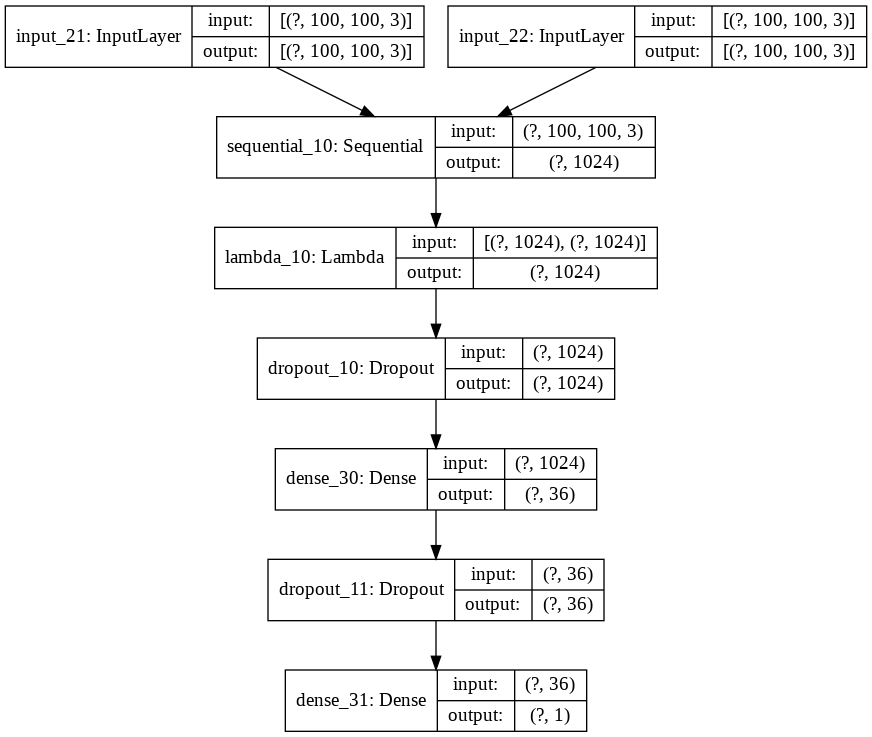

In [ ]:
K.utils.plot_model(siamese_net, "siamese_net_architecture.png", show_shapes=True)

## Training

In [ ]:
batch_size_value = 128
max_epochs_value = 50

early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=0.005, 
                                           patience=1, 
                                           verbose=1, 
                                           mode='auto', 
                                           baseline=None, 
                                           restore_best_weights=True)

history = siamese_net.fit(train_pairs, y_train,
                  batch_size = batch_size_value,
                  epochs = max_epochs_value,
                  validation_data = (val_pairs, y_val),
                  shuffle = True,
                  verbose=1,
                  callbacks=[early_stopping]
                  )

Epoch 1/50
24/24 [==============================] - 134s 6s/step - loss: 4.6093 - accuracy: 0.6364 - val_loss: 3.2652 - val_accuracy: 0.6796
Epoch 2/50
24/24 [==============================] - 133s 6s/step - loss: 2.6172 - accuracy: 0.7225 - val_loss: 2.0362 - val_accuracy: 0.7468
Epoch 3/50
24/24 [==============================] - 134s 6s/step - loss: 1.6817 - accuracy: 0.7883 - val_loss: 1.6385 - val_accuracy: 0.6619
Epoch 4/50
24/24 [==============================] - 135s 6s/step - loss: 1.2807 - accuracy: 0.8080 - val_loss: 1.2612 - val_accuracy: 0.7662
Epoch 5/50
24/24 [==============================] - 134s 6s/step - loss: 1.0175 - accuracy: 0.8433 - val_loss: 1.0139 - val_accuracy: 0.8124
Epoch 6/50
24/24 [==============================] - 134s 6s/step - loss: 0.8352 - accuracy: 0.8830 - val_loss: 1.0203 - val_accuracy: 0.8032
Epoch 00006: early stopping


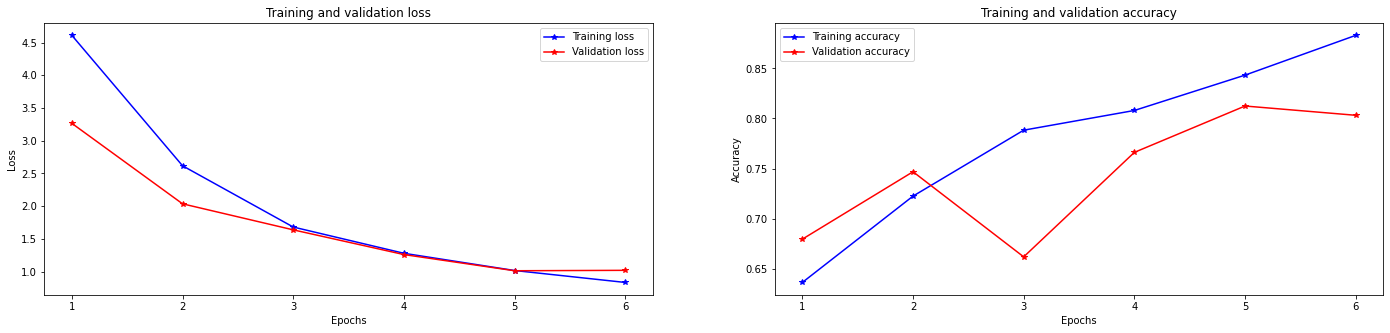

In [ ]:
# Plot Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(24,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss, '-*b', label='Training loss')
plt.plot(epochs, val_loss, '-*r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, acc, '-*b', label='Training accuracy')
plt.plot(epochs, val_acc, '-*r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation

In [ ]:
test_pred = siamese_net.predict(test_pairs)

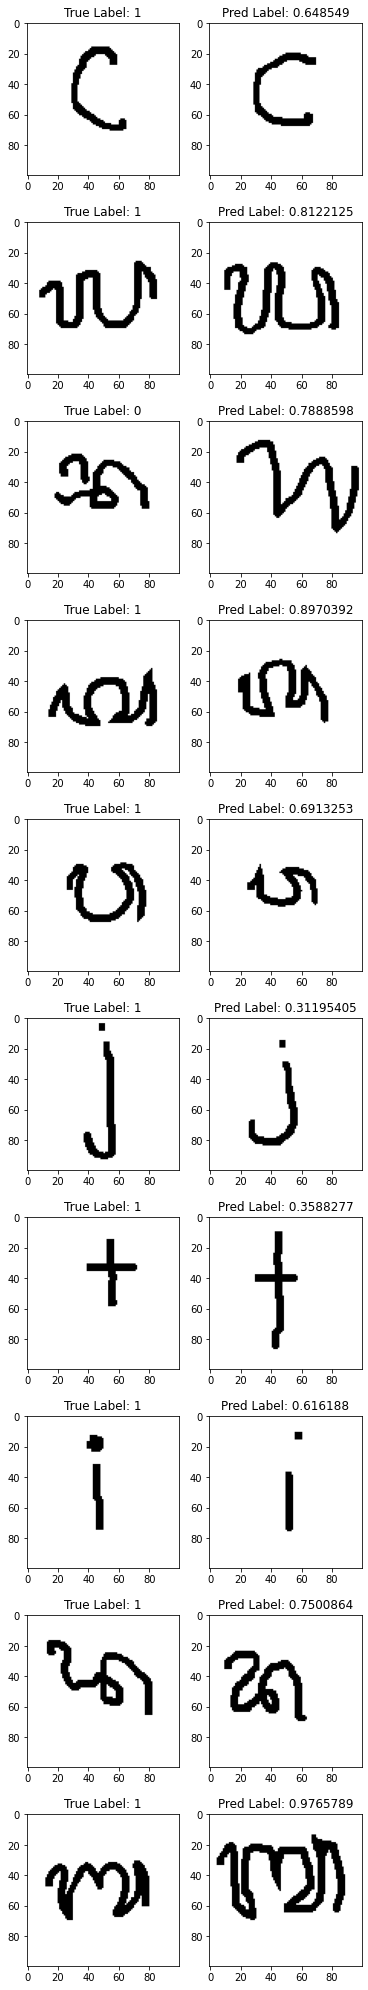

In [ ]:
plot_img_couples(test_pairs, true_labels=y_test, pred_labels=test_pred, n_couples_to_plot=10,
                 Plot_TP=True, Plot_FP=True, Plot_FN=True, Plot_TN=False)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, test_pred, pos_label=1, drop_intermediate = True)

In [ ]:
def calculate_optimal_threshold(x_val,y_val,thresholds):

  min_dist = 100
  for x,y,t in zip(x_val,y_val,thresholds):

      square_dist = (0-x)**2+(1-y)**2

      if square_dist<min_dist:

        min_dist = square_dist
        best_x = x
        best_y = y
        best_t = t

  return (best_x, best_y, best_t)

In [ ]:
best_fpr, best_tpr, best_threshold = calculate_optimal_threshold(fpr, tpr, thresholds)
best_fpr, best_tpr, best_threshold

(0.28, 0.7554092191909689, 0.5734037)

In [ ]:
AUC_score = np.round(roc_auc_score(y_test, test_pred),3)

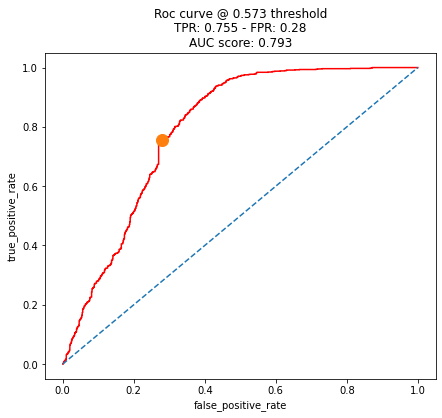

In [ ]:
plt_title = ('Roc curve @ '+str(np.round(best_threshold,3))+
            ' threshold\nTPR: '+str(np.round(best_tpr,3))+' - FPR: '+str(np.round(best_fpr,3))+
            '\nAUC score: '+str(AUC_score))

plt.figure(figsize=(7,6))
plt.plot(fpr,tpr,'-r', [0,1],[0,1],'--', best_fpr, best_tpr,'o', markersize=12)
plt.title(plt_title)
plt.xlabel('false_positive_rate')
plt.ylabel('true_positive_rate')
plt.show()

In [ ]:
confusion_matrix(y_test, test_pred>best_threshold, labels=None, sample_weight=None, normalize=None)

array([[576, 224],
       [261, 802]])

In [ ]:
confusion_matrix(y_test, test_pred>0.2, labels=None, sample_weight=None, normalize=None)

array([[ 408,  392],
       [  36, 1027]])

In [ ]:
accuracy_score(y_test, test_pred>best_threshold), accuracy_score(y_test, test_pred>0.5)

(0.7396672034353193, 0.750402576489533)

In [ ]:
average_precision_score(y_test, test_pred>best_threshold, pos_label=1)

0.7298468379537242